### Bayesian Data Analysis, 3rd ed
##  Chapter 4, demo 1

원저자:

- Aki Vehtari aki.vehtari@aalto.fi
- Tuomas Sivula tuomas.sivula@aalto.fi

2차저자:

- 문현지, 민태규

Bioassay model의 정규근사

p.87의 설명에 따르면, Bioassay model의 20개라는 적은 샘플수로 인해 주로 큰 샘플수를 가정하는 정규근사로 계산된 결과는 실제 시뮬레이션(샘플추출)로 구한 결과와 차이가 있다.

실제 결과는 근사와 비교해

$\alpha$, $\beta$의 결합분포가 더 skewed되고

LD50의 사후분포는 더 short tail를 가진다. 

이를 다음 코드를 통해 확인해본다.

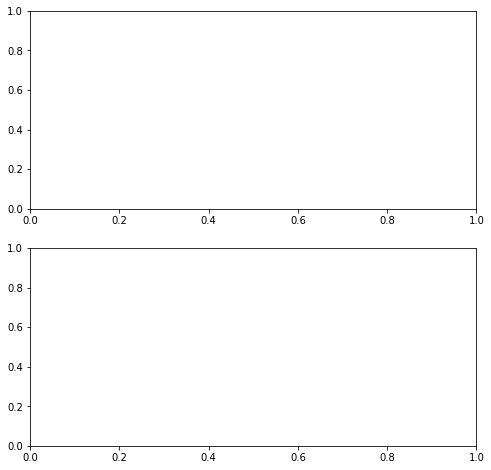

In [1]:
import numpy as np
from scipy import optimize, stats
from scipy.special import expit  # aka logistic
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
import plot_tools
plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background']);

In [2]:
# 데이터
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

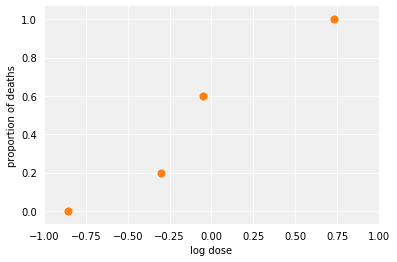

In [3]:
# 데이터 plot
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

In [4]:
# 사후분포밀도를 grid에서 계산
# - 일반적으로 log형태로 계산
# - 여러 사전분포를 실험해볼 경우 A, B의 범위와 간격이 적절한지 반드시 확인
ngrid = 100
A = np.linspace(-4, 8, ngrid)
B = np.linspace(-10, 40, ngrid)
ilogit_abx = 1/(np.exp(- (A[:, None] + B[:, None, None] * x)) + 1)
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis = 2)

다음은 for문을 이용한 p 사후분포 계산의 안좋은 예시다. 벡터화된 위 방식이 더 효율적이다. 물론 현재는 계산량이 많지 않아 큰 차이가 없다.

```python
p = np.empty((len(B),len(A))) # allocate space
for i in range(len(A)):
    for j in range(len(B)):
        ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
        p[j,i] = np.prod(ilogit_abx_ij**y * ilogit_abx_ij**(n - y))
```
메모리를 최적화하는 in-place statements이용시 더 효율적인 벡터표현이 가능하나 여기선 생략한다.

In [5]:
# grid에서 샘플링
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size = nsamp, p = np.ravel(p)/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]

# 샘플링된 결과가 연속분포가 되도록 0평균의 random jitter를 더한다(p.76)
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

# LD50의 샘플 
samp_ld50 = - samp_A / samp_B 

참고로, LD50은 사망률 50%에 해당하는 치사량으로, ($\alpha$ + $\beta$ * x) = logit^-1(0.5) = 0 이므로 x = - $\alpha$ / $\beta$를 대입한다.

근사를 위해 테일러 전개의 $\theta$는 사후분포의 mode를 이용한다. 이는 음 로그사후분포(negative log posterior)를 최소화함으로써 구할 수 있다. 기울기와 헤시안을 해석적으로 구하고, 최적화를 위해 Newton 알고리즘을 이용하라. 아래의 최적화 방법을 이용해 결과를 검사해보고, 추가적인 사항은 scipy.optimize.minimize 참조.

p.87에서 밝혔듯이, 정규근사는 큰 샘플수를 가정하므로 가능도가 사전분포를 압도하기 때문에 가능도를 사후분포로 이용할 수 있다 (n → ∞, the likelihood dominates the prior distribution, so we can just use the likelihood alone to obtain the mode and curvature for the normal approximation).

In [6]:
# define the optimised function
# 최적화 함수 정의
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# 초기 해 설정
w0 = np.array([0.0, 0.0])

# 최적화 진행
optim_res = optimize.minimize(bioassayfun, w0)

# 최적화 결과
w = optim_res['x']
S = optim_res['hess_inv']

optimize.minimize 함수는 첫번째 인자로 목적함수를, 두번째 인자로 초기해를 받습니다.



In [40]:
# grid로 정규근사 밀도계산
# alpha, beta의 사전샘플인 A, B로부터 (ngrid, ngrid, 2) shape의 grid구성
# Numpy's concatenation 함수는 broadcasting지원하지 않지만, 다음과 같은 방식으로 메모리 낭비 없이 구현가능 
# (strides관련 Numpy공식문서 참조)

A_broadcasted = np.lib.stride_tricks.as_strided(
    A, shape=(ngrid,ngrid), strides=(0, A.strides[0]))
B_broadcasted = np.lib.stride_tricks.as_strided(
    B, shape=(ngrid,ngrid), strides=(B.strides[0], 0))
grid = np.dstack((A_broadcasted, B_broadcasted))
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

# 분포로부터 샘플 추출, 앞서 구한 사후분포(= 가능도)의 mode w, S 이용
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

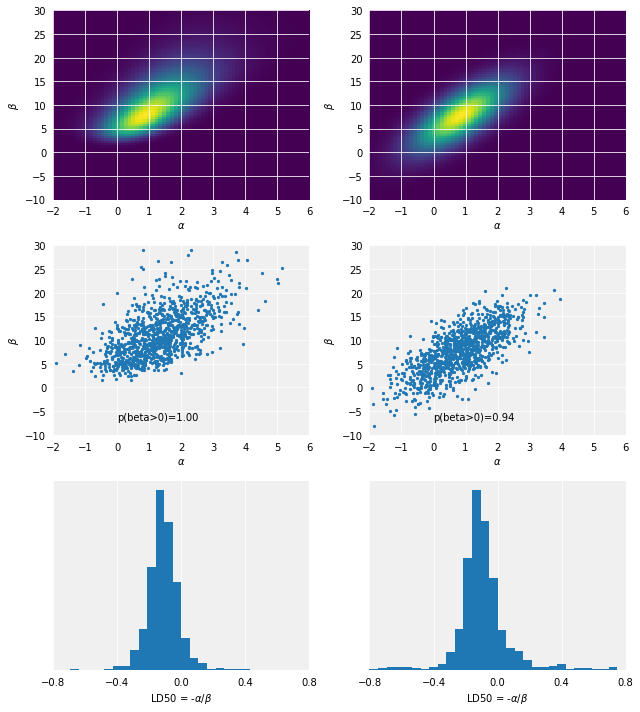

In [46]:
# figure 생성
fig, axes = plt.subplots(3, 2, figsize=(9, 10))

# 사후밀도 plot
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# 샘플 plot
ax = axes[1, 0]
ax.scatter(samp_A, samp_B, 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))


# LD50의 히스토그램 plot
ax = axes[2, 0]
ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

# 정규근사로 구한 사후분포 plot
ax = axes[0, 1]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')

# 정규근사로부터의 샘플 plot
ax = axes[1, 1]
ax.scatter(samp_norm[:,0], samp_norm[:,1], 5)
ax.set_xlim([-2, 6])
ax.set_ylim([-10, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')

# 정규근사는 다음 두 사실을 고려하지 못한다. 1. 사후분포가 대칭이 아님, 2. beta가 음수일 확률이 낮음
# 따라서 정규근사에 따르면 beta가 음수일 확률이 4%이상으로 나온다. 
ax.text(0, -7, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# LD50의 히스토그램 plot
ax = axes[2, 1]

# beta가 음수일 수 없다는 것과 관련해 강한 사전믿음이 있으므로 beta>0라는 조건을 걸면 정규근사를 개선가능.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
ax.hist(samp_ld50_norm, np.linspace(-0.8, 0.8, 31))
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.8, 0.8, 5))

fig.tight_layout()